# LoG Blob Detection (Assignment 6)

Giulia Ghisolfi

# 2. Code Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

## 2.1 LoG Filter Implementation

In [2]:
def LoG_filter(sigma, filter_size=None):
    """
    Returns a Laplacian of Gaussian (LoG) filter for a given sigma.

    Parameters:
    sigma (float):
        Scale value for the filter.
    filter_size (int):
        Size of the filter. If None, the filter size is calculated as ceil(6*sigma).

    Returns:
        LoG filter.
    """

    if not filter_size:
        filter_size = np.ceil(6 * sigma)  # std size smoothing mask

    num = np.floor(filter_size / 2)
    x = np.arange(-num, num+1, 1)
    y = np.arange(-num, num+1, 1)
    Gx, Gy = np.meshgrid(x, y)

    LoG_filter = - 1 / (np.pi * sigma ** 4) * (1 - (Gx ** 2 + Gy ** 2) /
                    (2 * sigma ** 2)) * np.exp(- (Gx ** 2 + Gy ** 2) / (2 * sigma ** 2))

    return LoG_filter

def normalized_LoG_filter(sigma, filter_size=None):
    """
    Returns a normalized Laplacian of Gaussian (LoG) filter for a given sigma.

    Parameters:
    sigma (float):
        Scale value for the filter.
    filter_size (int):
        Size of the filter. If None, the filter size is calculated as ceil(6*sigma).

    Returns:
        Normalized LoG filter.
    """

    return sigma ** 2 * LoG_filter(sigma, filter_size)

In [3]:
class LoG_Filter():
    """
    A class representing a Laplacian of Gaussian (LoG) filter for multiple scales.

    Attributes:
    sigma_list (list of float):
        Scale parameters, values of the standard deviation of the Gaussian used to
        compute the LoG filter for each scale.
    filter_size_list (list of int):
        Sizes of the filters used to compute the LoG filter for
        each scale parameter.

    Methods:
    create_kernel_set():
        Compute the LoG filter for each scale and return a list of filters.
    visualized_filter():
        Display the filters computed by create_kernel_set().
    """

    def __init__(self, sigma_list, filter_size_list=None):
        """
        Initialize a LoG_Filter object with the specified sigma_list and filter_size_list.

        Parameters:
            sigma_list (list of float):
                Scale parameters, values of the standard deviation of the Gaussian used to
                compute the LoG filter for each scale.
            filter_size_list (list of int):
                Sizes of the filters used to compute the LoG filter for each scale parameter.
                If None, the filter size is computed as 6 times the corresponding standard deviation.
        """

        self.sigma_list = sigma_list
        
        if not filter_size_list or (len(filter_size_list) != len(sigma_list)):  # filter size 
            self.filter_size_list = [np.ceil(6 * sigma) for sigma in sigma_list]

        else: self.filter_size_list = filter_size_list

    def create_kernel_set(self):
        self.kernel_list = []
        for sigma, filter_size in zip(self.sigma_list, self.filter_size_list):
            self.kernel_list.append(normalized_LoG_filter(sigma, filter_size))
        
        return self.kernel_list

    def visualized_filter(self):
        plt.figure(figsize=(18, 9))
        i = 0
        for kernel, sigma in zip(self.kernel_list, self.sigma_list):
            plt.subplot(1, len(self.kernel_list), i + 1)
            plt.imshow(kernel, cmap="gray")
            plt.title("Sigma: {:.2f}".format(sigma))
            i += 1
        plt.show()

### 2.1.1 Show Filter

To verify the correct implementation of the Gaussian filter the filter for different values ​​of the sigma scale parameter are shown. \
The filter appears to have the typical bell shape of the Gaussian.

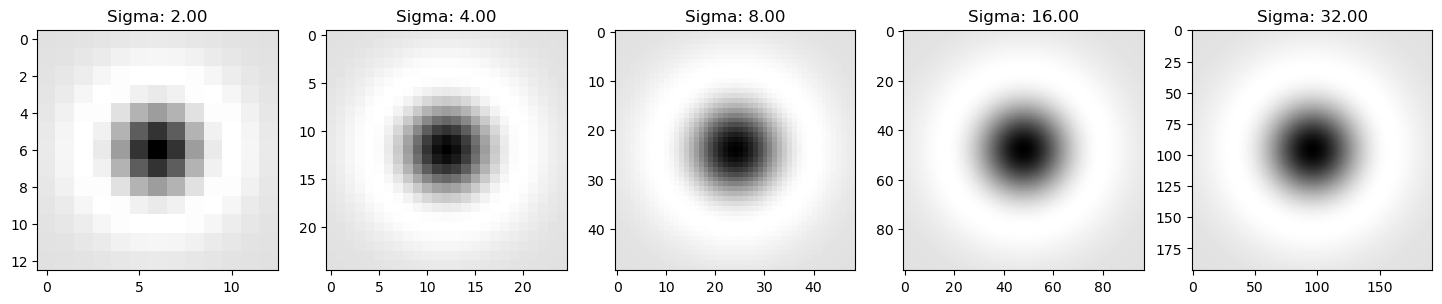

In [4]:
sigma0 = 1
sigma_list = [sigma0*2**k for k in range(1, 6)]

filter = LoG_Filter(sigma_list)
kernel_list = filter.create_kernel_set()  # create filter set
filter.visualized_filter()

## 2.2 Convolution Implementation

In [5]:
def convolution(kernel, image):
    """
    Convolves an input image with a kernel.

    Source:
    https://pyimagesearch.com/2016/07/25/convolutions-with-opencv-and-python/

    Parameters:
    kernel (array):
        LoG filter
    image (array)
    -  a numpy array representing the convolution kernel.

    Returns:
        Convolution between image and kernel.
    """
    kernel_size = kernel.shape[0]
    image_height, image_lenght = image.shape

    # pad the borders of the input image so the spatial size are not reduced
    pad = (kernel_size - 1) // 2
    image = cv2.copyMakeBorder(
        image, pad, pad, pad, pad, cv2.BORDER_REPLICATE)

    convolution_result = np.zeros((image_height, image_lenght))
    # results[0, 0] è in alto a sinistra
    for y in range(0, image_height):
        for x in range(0, image_lenght):
            convolution_result[y][x] = np.sum(
                kernel * image[y: y + kernel_size, x: x + kernel_size])

    return convolution_result

### 2.2.1 Utils

In [6]:
def show_convolution_results(response_list, sigma_list):
    """
    Display the results of the convolution by showing the response images.

    Parameters:
    response_list (list):
        Response of the convolution operation for different sigma values.
    sigma_list (list):
        Scale values used in the convolution operation.
    """

    plt.figure(figsize=(18, 9))
    for i, response in enumerate(response_list):
        plt.subplot(1, len(response_list), i+1)
        plt.imshow(response, cmap="gray")
        plt.title("Sigma: {:.2f}".format(sigma_list[i]))
    plt.show()

def convert_to_gray_scale(image):
    """
    Convert an RGB image to gray scale and normalize pixel values between 0 and 1.

    Parameters:
    image (array):
        RGB image.

    Returns:
        Gray scale image with pixel values normalized between 0 and 1.
    """
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 256

### 2.2.2 Show Convolution Results

For visualization purposes, the convolution response of a dataset image with the previously calculated filter is plotted below for different values of the scale parameter (sigma).

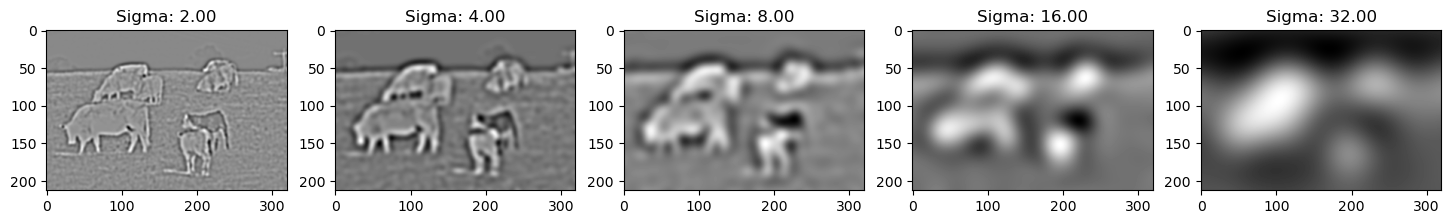

In [7]:
image_path = 'data/1_11_s.jpg'

# Loads image and converts it to grayscale
image = cv2.imread(image_path)
gray_scale_image = convert_to_gray_scale(image)

# Displays the convolution results if show_convolution flag is True
response_list = []
for kernel in kernel_list:
    response = convolution(kernel, gray_scale_image)
    response_list.append(response)
response_list = np.array(response_list)

show_convolution_results(response_list, sigma_list)

## 2.3 Blobs Detection Implementation

This section of the code implements a blob detector using the pre-computed LoG filter on a specified image. The detector is capable of identifying both bright and dark blobs and produces a visualization of the detected blobs, highlighting dark blobs in red and bright ones in green.

In [8]:
def detect_blobs(response_list, sigma_list, blob_type, blob_min_border_dist, blob_threshold):
    """
    Detect blobs in a given image convolved with a LoG filter.

    Parameters:
    response_list (list of tuples): 
        Response image to find blobs in.
    sigma_list (list of floats):
        Scale at which the response was computed.
    blob_type (str):
        Types of blobs to detect.
    blob_min_border_dist (int):
        Minimum distance of a blob from the image border. Default is 0.
    blob_threshold(float):
        Threshold value for blob detection.

    Returns:
        Two lists of tuples representing the detected blob, where each tuple contains (y_center, x_center, radius),
        the coordinates of the blob center and the blob radius.
    """
    dark_blobs = []
    bright_blobs = []
    
    z_max = response_list.shape[0]
    y_max = response_list.shape[1]
    x_max = response_list.shape[2]

    for z in range(0, z_max):
        radious = sigma_list[z]
        for y in range(blob_min_border_dist, y_max - blob_min_border_dist):
            for x in range(blob_min_border_dist, x_max - blob_min_border_dist):
                neighbours_response = []

                neighbours_response = [response_list[z_count][y_count][x_count]
                                   for z_count in range(max(0, z-1), min(z_max, z+2))
                                   for y_count in range(max(0, y-1), min(y_max, y+2))
                                   for x_count in range(max(0, x-1), min(x_max, x+2))]

                # Compare each pixel with all its neighthbourds, select the relative maxima
                if blob_type != "bright":
                    if (response_list[z, y, x] >= neighbours_response).all() and response_list[z, y, x] >= blob_threshold:
                        dark_blobs.append([y, x, radious])
                # select the relative minimum
                if blob_type != "dark":
                    if (response_list[z, y, x] <= neighbours_response).all() and response_list[z, y, x] <= -blob_threshold:
                        bright_blobs.append([y, x, radious])

    return np.array(dark_blobs), np.array(bright_blobs)

In [9]:
def remove_overlapping(blobs, overlapping_threshold):
    """
    Removes overlapping blobs from a list of detected blobs.

    Parameters:
    blobs (list of tuples):
        A list of tuples representing the detected blob, where each tuple contains (y_center, x_center, radius),
        the coordinates of the blob center and the blob radius.
    overlap_threshold (float):
        Threshold value for removing overlapping blobs.

    Returns:
        A list of tuples representing the non-overlapping blobs.
    """
    for i, blob1 in enumerate(blobs):
        if blob1[-1] != 0:
            for j in range(i+1, len(blobs)):
                blob2 = blobs[j]
                if compute_overlap_percentage(blob1, blob2) > overlapping_threshold:
                    
                    # deleting the smaller detected blob
                    if blob1[-1] > blob2[-1]:
                        blob2[-1] = 0
                    else:
                        blob1[-1] = 0
                        break
    
    return np.array([blob for blob in blobs if blob[-1] > 0])

def compute_overlap_percentage(blob1, blob2):
    """
    Computes the percentage of overlap between two blobs.

    Sources:
    https://mathworld.wolfram.com/Circle-CircleIntersection.html
    https://github.com/scikit-image/scikit-image/blob/master/skimage/feature/blob.py#L335

    Parameters:
    blob1, blob2 (tuple): 
        Each tuple contains (y_center, x_center, radius),
        the coordinates of the blob center and the blob radius.

    Returns:
        Percentage of overlap between the two blobs.
    """

    # radius of each blob
    r1 = blob1[2]
    r2 = blob2[2]

    # distance between the 2 centers
    d = (np.sum((blob1[:-1] - blob2[:-1]) ** 2))**(1/2)

    if d > r1 + r2:  # no overlap
        return 0
    elif d <= abs(r1 - r2):  # full overlap
        return 1
    else: # partial overlap: return the area of overlapping
        ratio1 = (d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1)
        ratio1 = np.clip(ratio1, -1, 1)
        acos1 = math.acos(ratio1)

        ratio2 = (d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2)
        ratio2 = np.clip(ratio2, -1, 1)
        acos2 = math.acos(ratio2)

        a = -d + r2 + r1
        b = d - r2 + r1
        c = d + r2 - r1
        d = d + r2 + r1

        area = (r1 ** 2 * acos1 + r2 ** 2 * acos2 -
                0.5 * (abs(a * b * c * d)**(1/2)))
        return area / (math.pi * (min(r1, r2) ** 2))

### 2.3.1 Utils

In [10]:
def show_blobs(image, gray_scale_image, dark_blobs, bright_blobs):
    """
    Display the blobs detected on the original grayscale image and
    the original image.
    Dark blobs are highlighted in red and bright ones in green.

    Parameters:
    image_path (str):
        File path of the original image .
    gray_scale_image (array):
        Gray scale image.
    dark_blobs, bright_blobs (list):
        Center coordinates and radius of the detected blobs.
    """

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    ax1.imshow(gray_scale_image, cmap="gray")
    for i in range(0, len(dark_blobs)):
        center = (int(dark_blobs[i][1]), int(dark_blobs[i][0]))
        radius = 2**(1/2) * dark_blobs[i][2]
        circle = plt.Circle(center, radius, color="red",
                            linewidth=0.8, fill=False)
        ax1.add_patch(circle)
    for i in range(0, len(bright_blobs)):
        center = (int(bright_blobs[i][1]), int(bright_blobs[i][0]))
        radius = 2**(1/2) * bright_blobs[i][2]
        circle = plt.Circle(center, radius, color="lime",
                            linewidth=0.8, fill=False)
        ax1.add_patch(circle)
    ax1.set_title("LoG Blob Detection")

    image = plt.imread(image_path)
    ax2.imshow(image)
    ax2.set_title("Original Image")

    plt.show()

### 2.3.2 Main Function

In [11]:
def LoG_blob_detection(image_path, sigma_list, filter_size_list=None, blob_type='both', show_filter=False, show_convolution=False,
                   blob_min_border_dist=0, blob_threshold=0, overlapping_threshold=0.1):
    """
    Detects blobs in an image using a given set of kernels and sigma values.

    Parameters:
    image_path (str):
        File path of the image to be processed.
    sigma_list (list of int):
        Sigma values for each kernel.
    filter_size_list (list of int):
        Sizes of the filters used to compute the LoG filter for
        each scale parameter.
    blob_type (str):
        Types of blobs to detect.
        Can take the values of "dark", "bright" or "both".
        Default value is "both".
    show_filter (bool):
        Flag to indicate whether the computed kernels should be displayed.
        Default is False.
    show_convolution (bool):
        Flag to indicate whether the results of the convolution should be displayed.
        Default is False.
    blob_min_border_dist (int):
        Minimum distance of a blob from the image border.
        Default is 0.
    blob_threshold (float):
        Threshold value for blob detection.
        Default is 0.
    overlapping_threshold (float):
        Threshold value for removing overlapping blobs.
        Default is 0.1.
    """

    # Compute kernels to be convolved with the image.
    filter = LoG_Filter(sigma_list, filter_size_list)
    kernel_list = filter.create_kernel_set()
    
    if show_filter:
        filter.visualized_filter()

    # Loads image and converts it to grayscale
    image = cv2.imread(image_path)
    gray_scale_image = convert_to_gray_scale(image)

    # Displays the convolution results if show_convolution flag is True
    response_list = []
    for kernel in kernel_list:
        response = convolution(kernel, gray_scale_image)
        response_list.append(response)
    response_list = np.array(response_list)

    if show_convolution:
        show_convolution_results(response_list, sigma_list)

    # Detects blobs in the response list and removes overlapping blobs
    if blob_type not in ["dark", "bright", "both"]: blob_type = "both"
    dark_blobs, bright_blobs = detect_blobs(response_list, sigma_list,
                      blob_type, blob_min_border_dist, blob_threshold)
    
    dark_blobs = remove_overlapping(
            dark_blobs, overlapping_threshold)
    bright_blobs = remove_overlapping(
            bright_blobs, overlapping_threshold)

    # Displays the original image with the detected blobs
    show_blobs(image_path, gray_scale_image, dark_blobs, bright_blobs)

# 3. Results

The Blobs detection algorithm has been tested on several images from different thematic classes. As the images were known in advance, different values for the scale and threshold parameters were set for each image in order to highlight interesting results. Each image was tested with two different parameter configurations

### Image 1_11_s

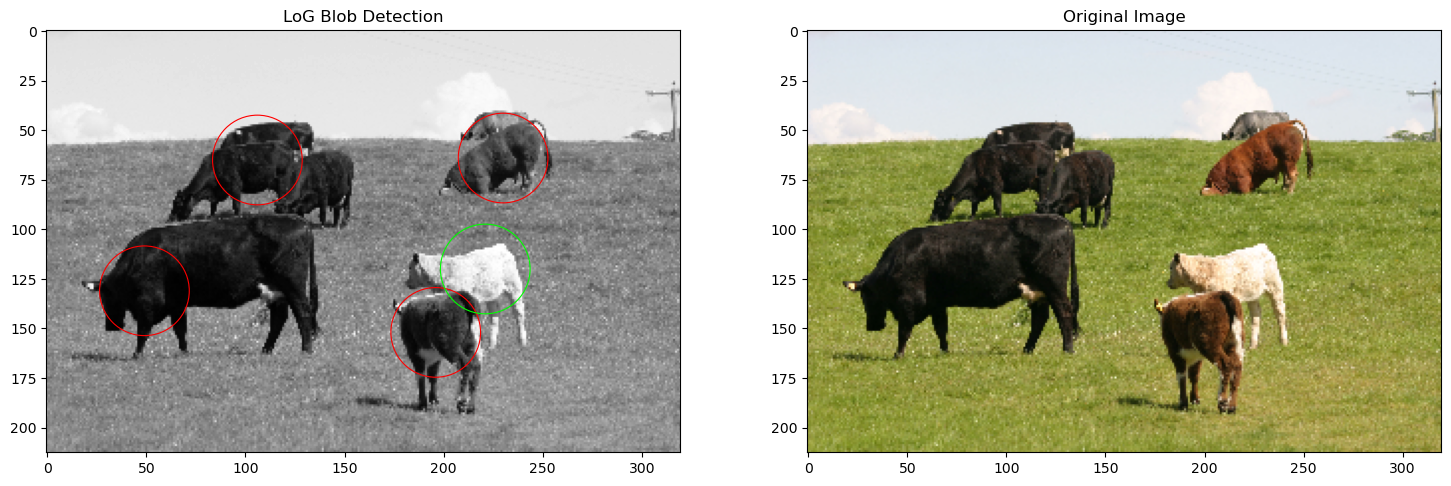

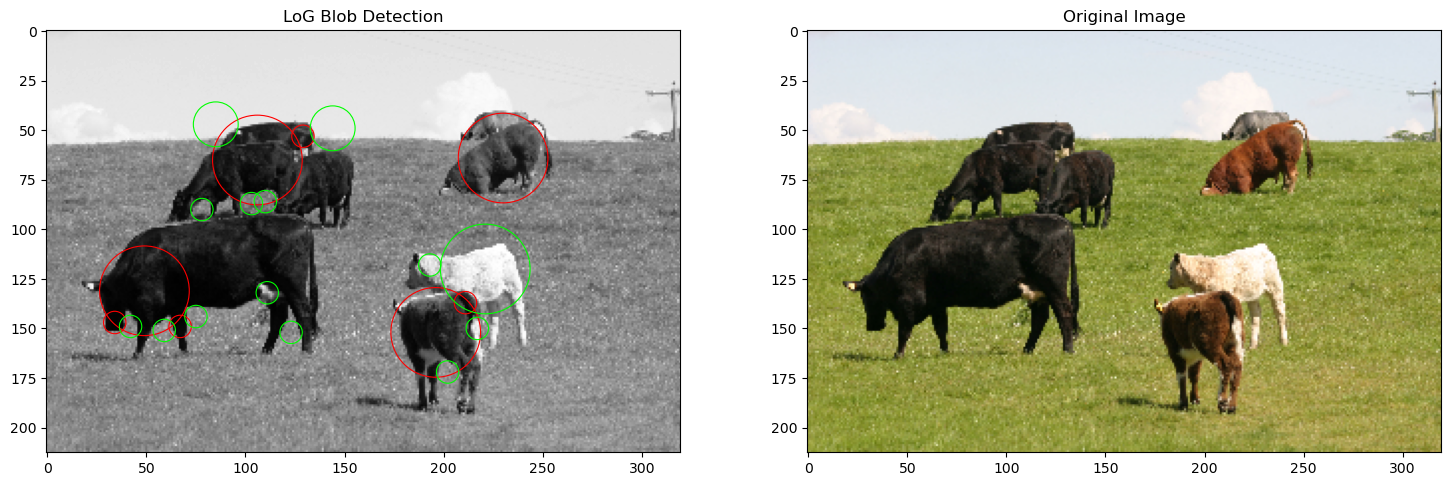

In [12]:
image_path = 'data/1_11_s.jpg'
sigma = [16]
LoG_blob_detection(image_path, sigma, blob_threshold=0.2)

sigma = [4, 8, 16]
LoG_blob_detection(image_path, sigma, blob_threshold=0.2)

In the first test, all the groups of animals were detected, the threshold was intentionally set high to eliminate background noise. In the second test, some lower sigma values were added, which resulted in some interesting responses, but the lower values also detected some noise, as predicted by the theory.

### Image 6_13_s

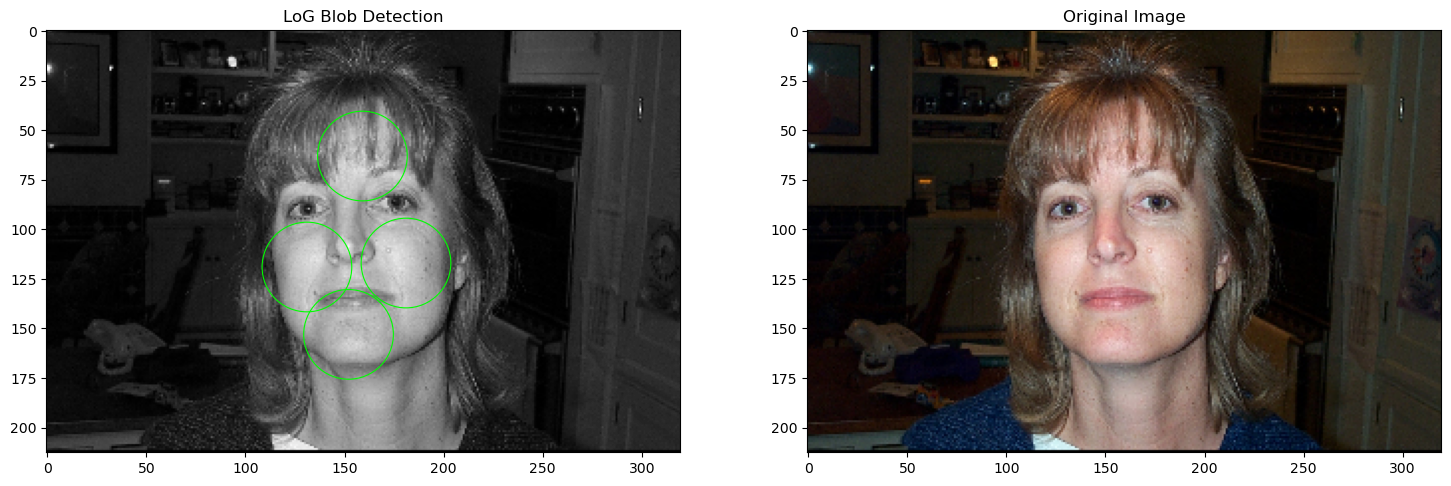

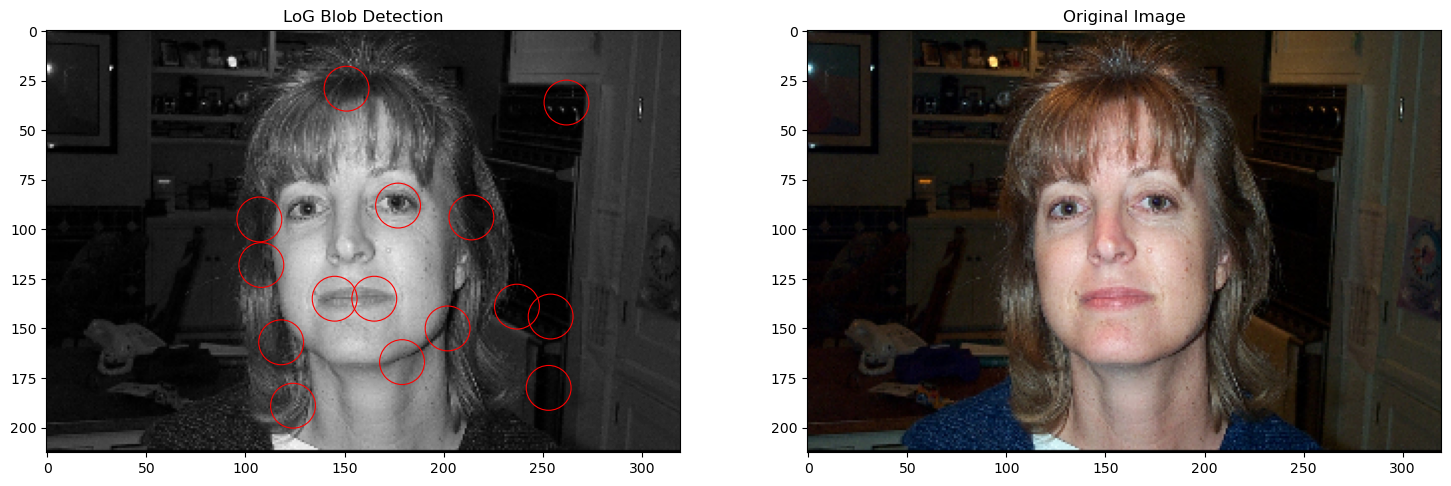

In [13]:
image_path = 'data/6_13_s.jpg'

sigma = [16]
LoG_blob_detection(image_path, sigma, blob_type="bright", blob_threshold=0.1, blob_min_border_dist=20)

sigma = [8]
LoG_blob_detection(image_path, sigma, blob_type="dark", blob_threshold=0.05, blob_min_border_dist=20)

In the first test, a bright blob was detected by setting a higher threshold value than that for dark blobs, as well as a minimum distance between the border and the center of the blobs to remove background noise. The algorithm successfully identified the chicks, chin, and forehead of the woman. In the second test, a dark blob was detected by using lower values of sigma and threshold. The algorithm was able to detect the mouth, the darkest part of the hair, and one eye. Lowering the threshold allowed the algorithm to detect the other eye as well, but with more noise in the background.

### Image 2_14_s

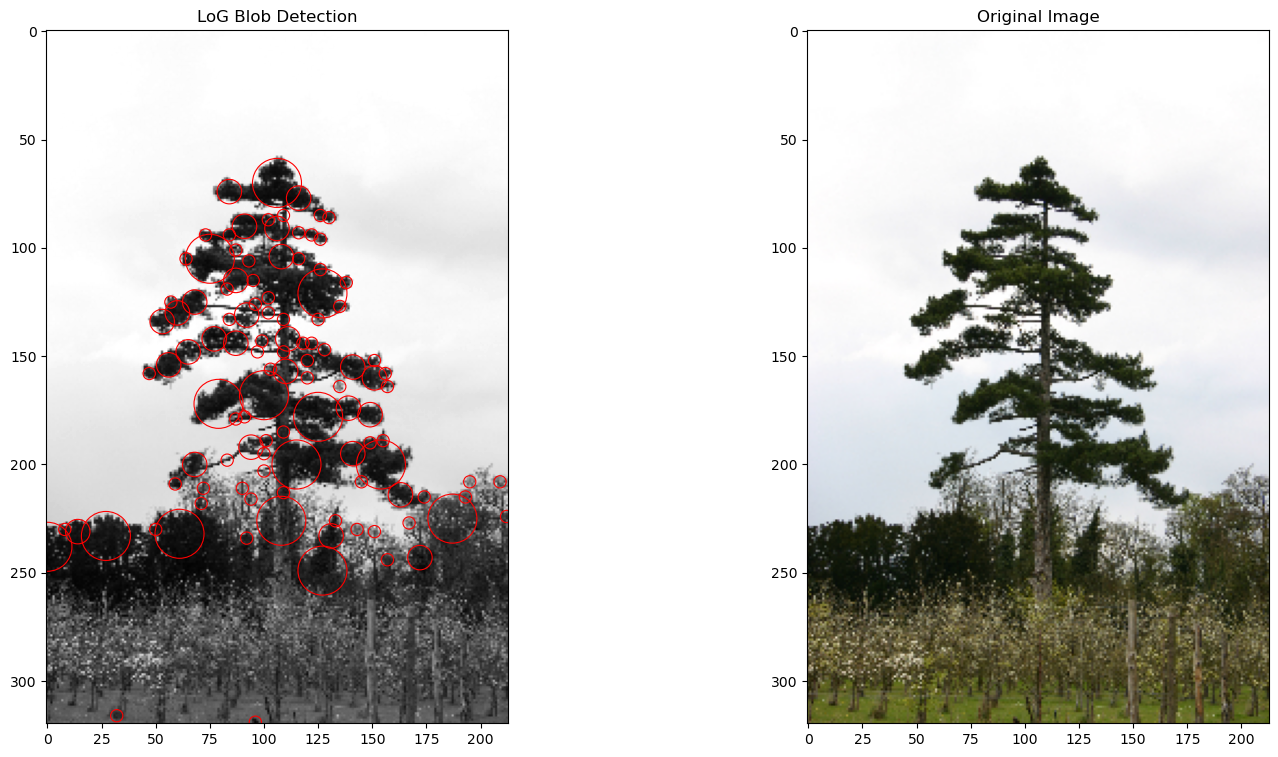

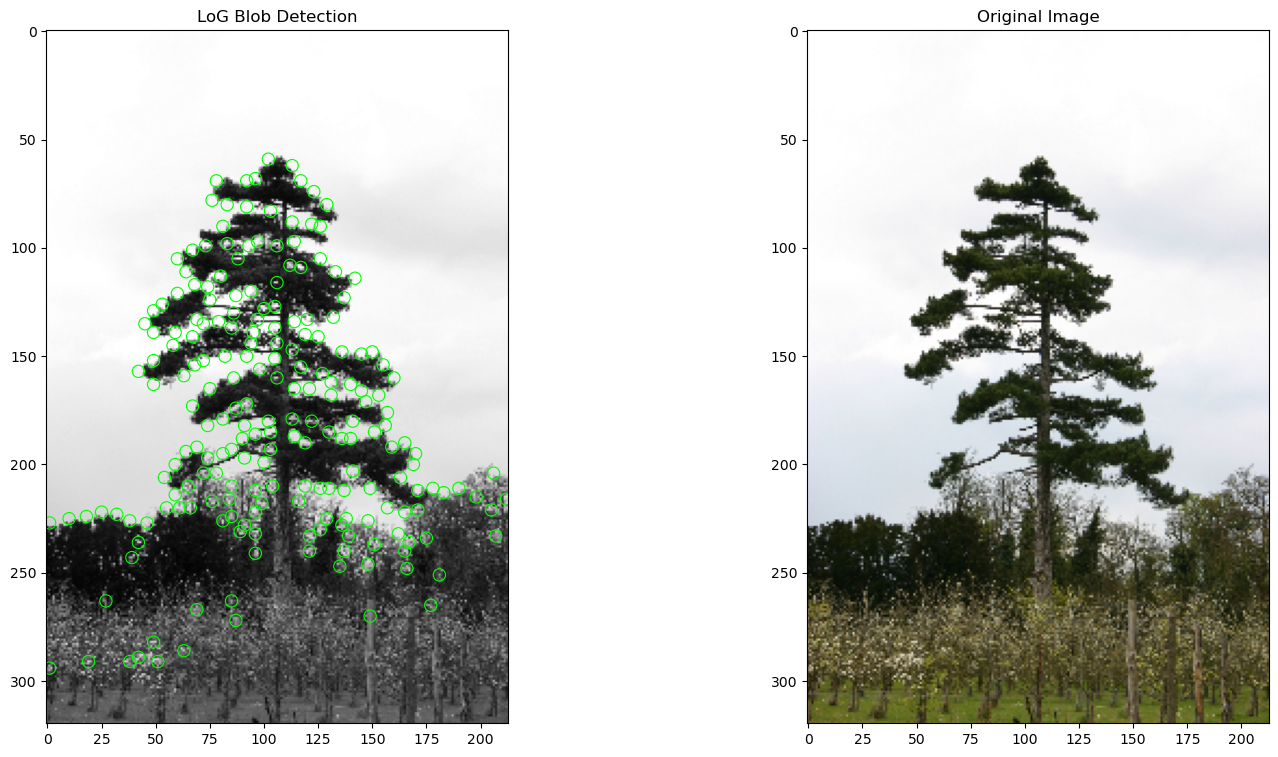

In [14]:
image_path = 'data/2_14_s.jpg'

sigma = [2, 4, 8]
LoG_blob_detection(image_path, sigma, blob_type="dark", blob_threshold=0.1)

sigma = [2]
LoG_blob_detection(image_path, sigma, blob_type="bright", blob_threshold=0.1)

The test detects dark and bright blobs separately, and it works well on the dark ones. The scale parameters are set low to achieve better precision. With high values of the scale and threshold parameters, the number of bright blobs detected is reduced. Additionally, it is important to note that in the test, the bright blobs are also identified as the tree's outline due to the high contrast between the foliage and the background.

### Image 5_23_s

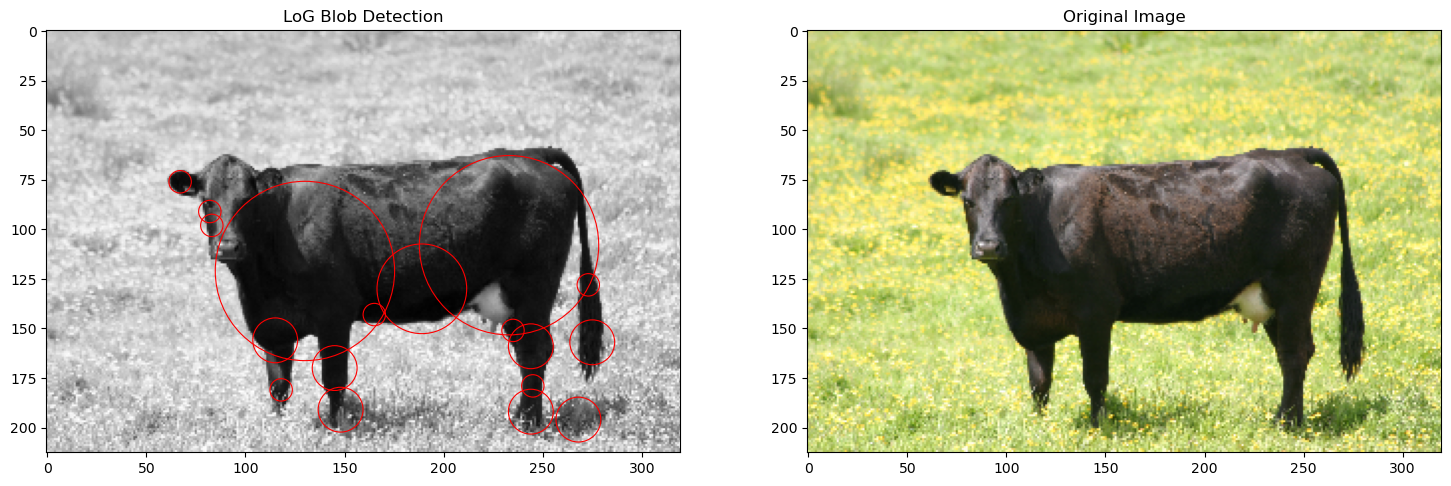

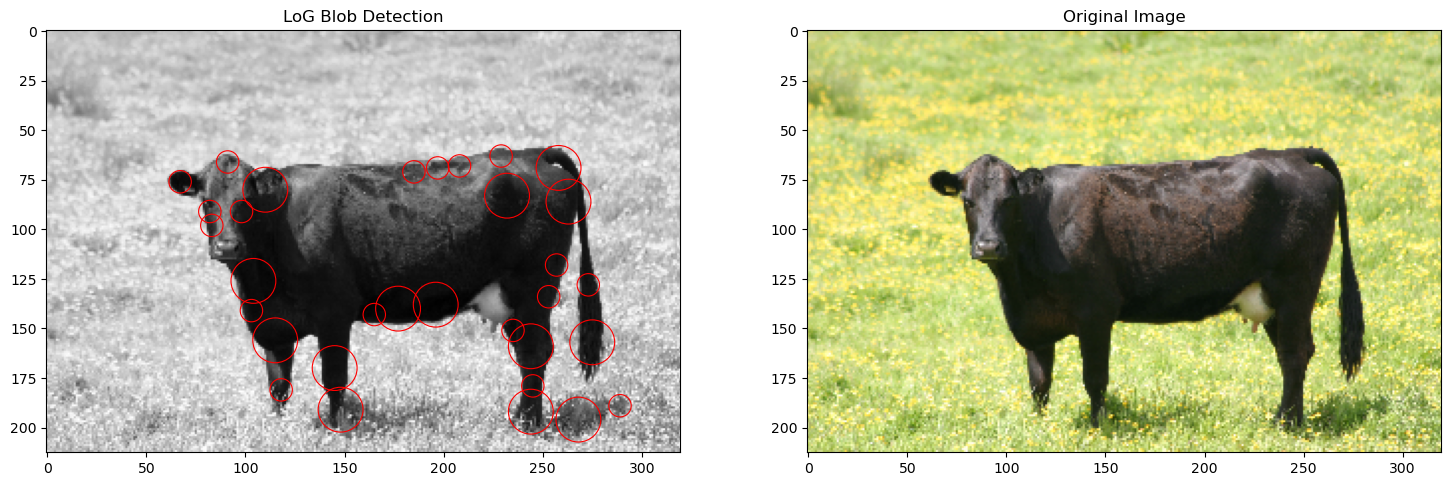

In [15]:
image_path = 'data/5_23_s.jpg'

sigma = [4, 8, 16, 32]
LoG_blob_detection(image_path, sigma, blob_type="dark", blob_threshold=0.15)

sigma = [4, 8]
LoG_blob_detection(image_path, sigma, blob_type="dark", blob_threshold=0.1)

This test focuses only on dark blobs. It shows that with lower values of sigma and threshold, the detection is more accurate, but it also deals with some noise.

# 4. Considerations

During the course of this project, it has become evident, in accordance with the theory, that choosing the right values of sigma and threshold is essential to achieving good results. However, there are still weak points in the algorithm that need to be addressed.

One such weak point is the loop in detect_blobs(), which involves six nested for-loops to find local maxima and minima in a three-dimensional tensor. These loops are computationally expensive.

Another issue that arises when using larger images with low values of sigma and threshold set to 0 is the problem of remove overlapping.

While the algorithm performs well with the example images provided, these iussues can lead to a significant increase in execution time if the algorithm is applied to detect blobs in a larger dataset. Therefore, it may be necessary to use libraries for better performance.

This project has been a valuable learning experience for me. It has helped me understand how to apply the theory discussed in class.